In [16]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#from ydata_profiling import ProfileReport
import webbrowser
import os


# Importação dos dados

In [17]:
df_energia21 = pd.read_csv('energia_202109-202112.csv', encoding='latin-1', keep_default_na=False) # keep_default_na=False para que o "None" apareca na injecao inves de "NAN"
df_energia22 = pd.read_csv('energia_202201-202212.csv', encoding='latin-1', keep_default_na=False)
df_energia_teste = pd.read_csv('energia_202301-202304.csv', encoding='latin-1')

df_meteo21 = pd.read_csv('meteo_202109-202112.csv', encoding='latin-1')
df_meteo22 = pd.read_csv('meteo_202201-202212.csv', encoding='latin-1')
df_meteo_teste = pd.read_csv('meteo_202301-202304.csv', encoding='latin-1')

# Merge do Dataset

In [18]:
df_energia_merged = pd.concat([df_energia21, df_energia22], ignore_index=True)
df_meteo_merged = pd.concat([df_meteo21, df_meteo22], ignore_index=True)

In [19]:
df_energia_merged['DataHora'] = pd.to_datetime(df_energia_merged['Data'] + ' ' + df_energia_merged['Hora'].astype(str) + ':00:00')
df_meteo_merged['DataHora'] = pd.to_datetime(df_meteo_merged['dt_iso'].str.replace(' +0000 UTC', '', regex=False))
df_treino = pd.merge(df_energia_merged, df_meteo_merged, on='DataHora', how='outer')

# Reordena as colunas para por DataHora como a primeira
cols = ['DataHora'] + [col for col in df_treino.columns if col != 'DataHora']
df_treino = df_treino[cols]

In [20]:
df_energia_teste['DataHora'] = pd.to_datetime(df_energia_teste['Data'] + ' ' + df_energia_teste['Hora'].astype(str) + ':00:00')
df_meteo_teste['DataHora'] = pd.to_datetime(df_meteo_teste['dt_iso'].str.replace(' +0000 UTC', '', regex=False))

df_teste = pd.merge(df_energia_teste, df_meteo_teste, on='DataHora', how='outer')

# Reordena as colunas para por DataHora como a primeira
cols = ['DataHora'] + [col for col in df_teste.columns if col != 'DataHora']
df_teste = df_teste[cols]

# Análise Exploratória dos Dados

### Profiling

In [21]:
"""# Carregar dataset
path = "Datasets/Datasets/the_oscar_award.csv"
df = pd.read_csv(path)

# Criar relatório
report = ProfileReport(df, title="Oscar Awards Profiling", explorative=True)

# Guardar ficheiro HTML
output_path = "profile.html"
report.to_file(output_path)

# Obter caminho absoluto e abrir no browser
abs_path = os.path.abspath(output_path)
webbrowser.open(f"file://{abs_path}")
print(f"Relatório aberto no browser: file://{abs_path}")"""

'# Carregar dataset\npath = "Datasets/Datasets/the_oscar_award.csv"\ndf = pd.read_csv(path)\n\n# Criar relatório\nreport = ProfileReport(df, title="Oscar Awards Profiling", explorative=True)\n\n# Guardar ficheiro HTML\noutput_path = "profile.html"\nreport.to_file(output_path)\n\n# Obter caminho absoluto e abrir no browser\nabs_path = os.path.abspath(output_path)\nwebbrowser.open(f"file://{abs_path}")\nprint(f"Relatório aberto no browser: file://{abs_path}")'

In [22]:
df = df_treino.copy()

for col in df.columns:
    num_missing = df[col].isnull().sum()
    perc_missing = num_missing / len(df) * 100
    num_unique = df[col].nunique()
    
    print(f"Column: {col}, {df[col].dtype}")
    print(f"Valores possiveis: {df[col].unique()[:2]} ...")
    print(f" - Missing Values: {num_missing} ({perc_missing:.2f}%)")
    print(f" - Preenchidos: {100-perc_missing:.2f}%")
    print(f" - Unique Values: {num_unique}")
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        print(f"    - Min: {df[col].min()}")
        print(f"    - Max: {df[col].max()}")
        print(f"    - Mean: {df[col].mean()}")
        print(f"    - Std Dev: {df[col].std()}")
    print()

Column: DataHora, datetime64[ns]
Valores possiveis: <DatetimeArray>
['2021-09-01 00:00:00', '2021-09-01 01:00:00']
Length: 2, dtype: datetime64[ns] ...
 - Missing Values: 0 (0.00%)
 - Preenchidos: 100.00%
 - Unique Values: 11688

Column: Data, object
Valores possiveis: [nan '2021-09-29'] ...
 - Missing Values: 672 (5.75%)
 - Preenchidos: 94.25%
 - Unique Values: 459

Column: Hora, float64
Valores possiveis: [nan  0.] ...
 - Missing Values: 672 (5.75%)
 - Preenchidos: 94.25%
 - Unique Values: 24
    - Min: 0.0
    - Max: 23.0
    - Mean: 11.5
    - Std Dev: 6.922500761666925

Column: Normal (kWh), float64
Valores possiveis: [nan  0.] ...
 - Missing Values: 672 (5.75%)
 - Preenchidos: 94.25%
 - Unique Values: 1282
    - Min: 0.0
    - Max: 3.251
    - Mean: 0.20227805010893246
    - Std Dev: 0.3494782869100058

Column: Horário Económico (kWh), float64
Valores possiveis: [nan  0.] ...
 - Missing Values: 672 (5.75%)
 - Preenchidos: 94.25%
 - Unique Values: 851
    - Min: 0.0
    - Max: 6.9

### Duplicados

In [23]:
# Verifica quais linhas estão duplicadas
duplicados = df_treino.duplicated()
# Conta o número de linhas duplicadas
num_duplicados = duplicados.sum()
num_duplicados

np.int64(0)

In [24]:
# Verifica quais linhas estão duplicadas
duplicados = df_teste.duplicated()
# Conta o número de linhas duplicadas
num_duplicados = duplicados.sum()
num_duplicados

np.int64(0)

### Análise geral

In [25]:
display(df_energia_merged[["Data","Hora"]].head(1))
display(df_meteo_merged[["dt_iso"]].head(1))

display(df_energia_teste[["Data","Hora"]].head(1))
display(df_meteo_teste[["dt_iso"]].head(1))

,Data,Hora
0,2021-09-29,0


,dt_iso
0,2021-09-01 00:00:00 +0000 UTC


,Data,Hora
0,2023-01-01,0


,dt_iso
0,2023-01-01 00:00:00 +0000 UTC


In [26]:
display(df_energia_merged[["Data","Hora"]].tail(1))
display(df_meteo_merged[["dt_iso"]].tail(1))

display(df_energia_teste[["Data","Hora"]].tail(1))
display(df_meteo_teste[["dt_iso"]].tail(1))

,Data,Hora
11015,2022-12-31,23


,dt_iso
11687,2022-12-31 23:00:00 +0000 UTC


,Data,Hora
2255,2023-04-04,23


,dt_iso
1751,2023-03-14 23:00:00 +0000 UTC


No dataset de treino, a informacao comeca a 29/09/2021 (meteorologia comeca a 01/09, mas ha um periodo onde n temos informacao da energia), ambas acabam a 31/12/2022 as 23 horas;

No dataset de teste, a informação comeca toda a 01/01/2023, mas energia acaba a 4/4 e meteo acaba a 14/3, com isto existe um periodo onde n temos dados de meteorologia, mais uma vez, podemos descartar;

### Tipos e Valores nulos

DataHora                   datetime64[ns]
Data                               object
Hora                              float64
Normal (kWh)                      float64
Horário Económico (kWh)           float64
Autoconsumo (kWh)                 float64
Injeção na rede (kWh)              object
dt                                  int64
dt_iso                             object
city_name                          object
temp                              float64
feels_like                        float64
temp_min                          float64
temp_max                          float64
pressure                            int64
sea_level                         float64
grnd_level                        float64
humidity                            int64
wind_speed                        float64
rain_1h                           float64
clouds_all                          int64
weather_description                object
dtype: object
DataHora                     0.000000
Data                    

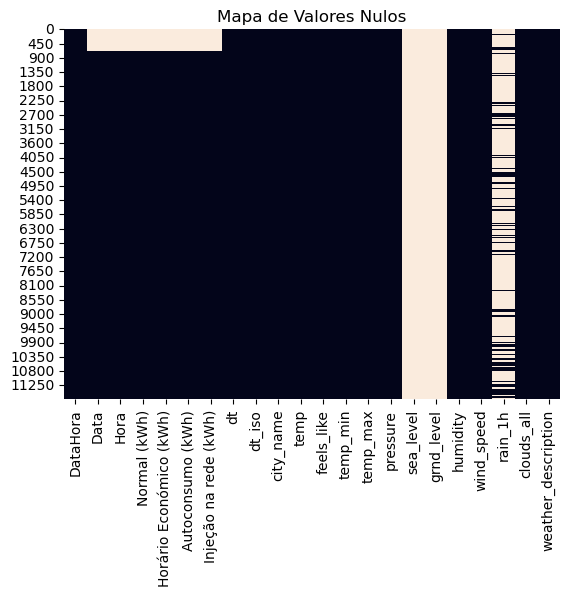

In [27]:
print(df_treino.dtypes)
print(df_treino.isnull().sum()*100/len(df_treino))
sns.heatmap(df_treino.isna(), cbar=False)
plt.title("Mapa de Valores Nulos")
plt.show()

Portanto, os 5.75% sao justicados pelo facto de nao termos dados da energia de 1 a 28 de setembro;

sea_level e grnd_level estao completamente nulas, podemos eliminar a coluna;

Se calhar tambem podemos eliminar rain_1h, temos que ver o que ela representa e se podemos usar na mesma (substituindo os valores nulos ou deixando estar)

DataHora                   datetime64[ns]
Data                               object
Hora                                int64
Normal (kWh)                      float64
Horário Económico (kWh)           float64
Autoconsumo (kWh)                 float64
dt                                float64
dt_iso                             object
city_name                          object
temp                              float64
feels_like                        float64
temp_min                          float64
temp_max                          float64
pressure                          float64
sea_level                         float64
grnd_level                        float64
humidity                          float64
wind_speed                        float64
rain_1h                           float64
clouds_all                        float64
weather_description                object
dtype: object
DataHora                     0.000000
Data                         0.000000
Hora                        

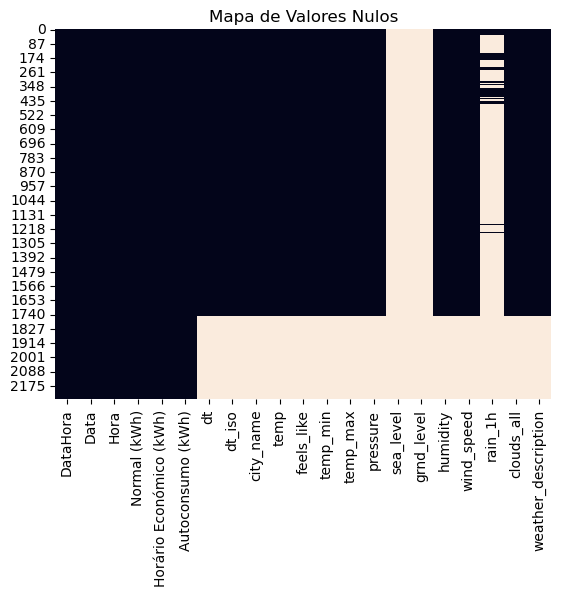

In [28]:
print(df_teste.dtypes)
print(df_teste.isnull().sum()*100/len(df_teste))
sns.heatmap(df_teste.isna(), cbar=False)
plt.title("Mapa de Valores Nulos")
plt.show()

Mais uma vez, sea_level e grnd_level completamente nulos, podemos eliminar. 22.34% Representa as datas para as quais nao temos dados de meteorologia (15/3 a 4/4);

Mesmo tambem para rain_1h;

### Valores possíveis

In [29]:
for col in df_treino.columns:
    uni = df_treino[col].unique()
    if len(uni) < 50:
        print(col)
        print(uni)

Hora
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23.]
Injeção na rede (kWh)
[nan 'None' 'Low' 'Medium' 'High' 'Very High']
city_name
['local']
pressure
[1015 1014 1013 1016 1017 1018 1019 1012 1011 1020 1010 1009 1008 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1007 1006 1005 1003 1002 1000
  999  997  998 1004 1030 1031 1001 1032 1033 1034  996  995  994]
sea_level
[nan]
grnd_level
[nan]
weather_description
['broken clouds' 'overcast clouds' 'light rain' 'moderate rain'
 'heavy intensity rain' 'scattered clouds' 'sky is clear' 'few clouds']


In [30]:
for col in df_teste.columns:
    uni = df_teste[col].unique()
    if len(uni) < 50:
        print(col)
        print(uni)

Hora
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
city_name
['local' nan]
pressure
[1019. 1018. 1017. 1016. 1015. 1014. 1020. 1021. 1022. 1023. 1024. 1025.
 1026. 1027. 1028. 1029. 1030. 1031. 1032. 1033. 1034. 1035. 1036. 1012.
 1011. 1013. 1010. 1009. 1008. 1007. 1006.   nan]
sea_level
[nan]
grnd_level
[nan]
weather_description
['moderate rain' 'heavy intensity rain' 'light rain' 'overcast clouds'
 'scattered clouds' 'few clouds' 'sky is clear' 'broken clouds' nan]


Podemos tabem remover city_name pq so tem um valor possivel

### Valores fora do Dominio

In [31]:
df_treino.describe()

,DataHora,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all
count,11688,11016.000000,11016.000000,11016.000000,11016.000000,1.168800e+04,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,0.0,0.0,11688.000000,11688.000000,2435.000000,11688.000000
mean,2022-05-02 11:29:59.999999744,11.500000,0.202278,0.159714,0.117314,1.651491e+09,16.406638,16.076164,14.433353,17.502990,1018.304073,NaN,NaN,76.619011,2.647688,0.884760,54.258214
min,2021-09-01 00:00:00,0.000000,0.000000,0.000000,0.000000,1.630454e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,NaN,NaN,19.000000,0.060000,0.100000,0.000000
25%,2021-12-31 17:45:00,5.750000,0.000000,0.000000,0.000000,1.640973e+09,12.350000,11.760000,10.900000,12.930000,1015.000000,NaN,NaN,66.000000,1.610000,0.210000,7.000000
50%,2022-05-02 11:30:00,11.500000,0.000000,0.000000,0.000000,1.651491e+09,15.760000,15.675000,14.540000,16.720000,1018.000000,NaN,NaN,81.000000,2.380000,0.450000,60.000000
75%,2022-09-01 05:15:00,17.250000,0.314000,0.288000,0.227000,1.662009e+09,19.540000,19.560000,17.720000,20.700000,1022.000000,NaN,NaN,91.000000,3.400000,1.070000,98.000000
max,2022-12-31 23:00:00,23.000000,3.251000,6.978000,1.192000,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,NaN,NaN,100.000000,11.100000,7.450000,100.000000
std,NaN,6.922501,0.349478,0.271792,0.176762,1.214705e+07,5.715977,6.217605,4.960590,6.112344,6.109727,NaN,NaN,16.157421,1.458574,1.073453,40.443374


In [32]:
df_teste.describe()

,DataHora,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all
count,2256,2256.000000,2256.000000,2256.000000,2256.000000,1.752000e+03,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,0.0,0.0,1752.000000,1752.000000,206.000000,1752.000000
mean,2023-02-16 23:29:59.999999744,11.500000,0.268060,0.226809,0.119439,1.675683e+09,10.599606,9.543265,9.177917,11.643813,1023.493721,NaN,NaN,75.639840,2.873613,1.025097,44.489726
min,2023-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,1.672531e+09,0.930000,-1.790000,-0.850000,3.340000,1006.000000,NaN,NaN,23.000000,0.120000,0.110000,0.000000
25%,2023-01-24 11:45:00,5.750000,0.000000,0.000000,0.000000,1.674107e+09,7.877500,6.217500,6.247500,8.900000,1020.000000,NaN,NaN,62.000000,1.800000,0.250000,0.000000
50%,2023-02-16 23:30:00,11.500000,0.000000,0.000000,0.000000,1.675683e+09,10.950000,10.135000,9.710000,11.820000,1024.000000,NaN,NaN,81.000000,2.490000,0.565000,35.000000
75%,2023-03-12 11:15:00,17.250000,0.398750,0.336000,0.237250,1.677259e+09,13.292500,12.742500,12.320000,14.040000,1029.000000,NaN,NaN,91.000000,3.500000,1.245000,96.000000
max,2023-04-04 23:00:00,23.000000,3.381000,2.771000,1.161000,1.678835e+09,20.610000,19.790000,20.010000,22.010000,1036.000000,NaN,NaN,97.000000,10.320000,6.380000,100.000000
std,NaN,6.923721,0.464323,0.375752,0.190601,1.821251e+06,3.715156,4.191224,4.021176,3.596882,6.650873,NaN,NaN,17.415468,1.620450,1.209617,42.972438


In [33]:
def iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound